In [1]:
from lale.datasets.uci.uci_datasets import fetch_drugscom
from sklearn.model_selection import train_test_split
train_X_all, train_y_all, test_X, test_y = fetch_drugscom()
#subset to reduce overfitting and speed up experimentation
train_X, train_X_ignore, train_y, train_y_ignore = train_test_split(
    train_X_all, train_y_all, train_size=0.1, random_state=42)
print(f'shapes: train_X {train_X.shape}, test_X {test_X.shape}')
train_X.head()

shapes: train_X (16129, 5), test_X (53766, 5)


/home/hirzel/python3.6venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,drugName,condition,review,date,usefulCount
10015,Ethinyl estradiol / etonogestrel,Birth Control,"""I was 18 when I used this. The only problem I...","March 6, 2013",18
60369,Etonogestrel,Birth Control,"""I got the Nexplanon implant back in July 2016...","October 20, 2016",4
35706,Ethinyl estradiol / norgestimate,NaN,"""I have been on this birth control for a few y...","May 22, 2016",1
25223,Hylan g-f 20,Osteoarthritis,"""I had a knee injury over 10 years ago and was...","July 3, 2012",95
144741,Naloxegol,"Constipation, Drug Induced","""Please, please read this before trying any pr...","February 26, 2017",70


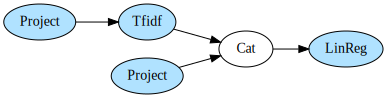

In [2]:
from lale.lib.lale import Project
from lale.lib.lale import ConcatFeatures as Cat
from lale.lib.sklearn import TfidfVectorizer as Tfidf
from lale.lib.sklearn import LinearRegression as LinReg
from lale.helpers import to_graphviz
prep_text = Project(columns=['review']) >> Tfidf(max_features=100)
prep_nums = Project(columns={'type': 'number'})
trainable = (prep_text & prep_nums) >> Cat >> LinReg()
to_graphviz(trainable)

In [3]:
trained = trainable.fit(train_X, train_y)

In [4]:
import math
from sklearn.metrics import mean_squared_error
predicted = trained.predict(test_X)
comparisons = [f'{int(test_y[i])}:{predicted[i]:.1f}' for i in range(10)]
print(f'comparisons [{", ".join(comparisons)}]')
rmse = math.sqrt(mean_squared_error(predicted, test_y))
print(f'rmse {rmse:.2f}')

comparisons [10:7.9, 8:8.9, 9:5.7, 9:8.1, 9:6.1, 4:7.2, 6:5.7, 9:7.9, 7:6.9, 2:5.9]
rmse 2.97


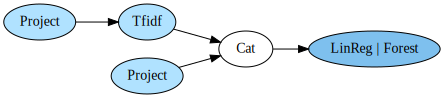

In [5]:
from lale.lib.sklearn import RandomForestRegressor as Forest
planned = (prep_text & prep_nums) >> Cat >> (LinReg | Forest)
to_graphviz(planned)

In [6]:
from lale.lib.lale import HyperoptClassifier
import sys
try: #TODO: debug this
    hyperopt_classifier = HyperoptClassifier(planned, max_evals=5)
    best_found = hyperopt_classifier.fit(train_X, train_y)
    to_graphviz(best_found)
except TypeError as e:
    print(str(e), file=sys.stderr)

unhashable type: 'list'
